<a href="https://colab.research.google.com/github/Uttpal-Tripathy/DDoS-Attack-detection/blob/main/RlL_Based_DDoS_Detection_in_cloud_using_ICM_based_PPO_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/cicddos2019_dataset.csv')
data

,Unnamed: 0,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Avg Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Fwd Win Bytes,Init Bwd Win Bytes,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Class
0,0,17,216631,6,0,2088.0,0.0,393.0,321.0,348.0,35.088460,0.0,0.0,0.0,0.0,9.638510e+03,27.696867,43326.200000,59304.016000,108616.0,0.0,216631.0,43326.200000,59304.016000,108616.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,96,0,27.696867,0.0,321.0,393.0,344.14285,33.617596,1130.1428,0,0,0,0,0,0,0,0,0.0,401.5,348.0,0.0,0,0,0,0,0,0,6,2088,0,0,-1,-1,5.0,1.400000e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
1,1,17,2,2,0,802.0,0.0,401.0,401.0,401.0,0.000000,0.0,0.0,0.0,0.0,4.010000e+08,1000000.000000,2.000000,0.000000,2.0,2.0,2.0,2.000000,0.000000,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,1000000.000000,0.0,401.0,401.0,401.00000,0.000000,0.0000,0,0,0,0,0,0,0,0,0.0,601.5,401.0,0.0,0,0,0,0,0,0,2,802,0,0,-1,-1,1.0,2.000000e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
2,2,17,48,2,0,766.0,0.0,383.0,383.0,383.0,0.000000,0.0,0.0,0.0,0.0,1.595833e+07,41666.668000,48.000000,0.000000,48.0,48.0,48.0,48.000000,0.000000,48.0,48.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,41666.668000,0.0,383.0,383.0,383.00000,0.000000,0.0000,0,0,0,0,0,0,0,0,0.0,574.5,383.0,0.0,0,0,0,0,0,0,2,766,0,0,-1,-1,1.0,2.000000e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
3,3,17,107319,4,0,1398.0,0.0,369.0,330.0,349.5,22.516660,0.0,0.0,0.0,0.0,1.302658e+04,37.272057,35773.000000,61959.790000,107318.0,0.0,107319.0,35773.000000,61959.790000,107318.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,80,0,37.272057,0.0,330.0,369.0,345.60000,21.361180,456.3000,0,0,0,0,0,0,0,0,0.0,432.0,349.5,0.0,0,0,0,0,0,0,4,1398,0,0,-1,-1,3.0,2.000000e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
4,4,17,107271,4,0,1438.0,0.0,389.0,330.0,359.5,34.063667,0.0,0.0,0.0,0.0,1.340530e+04,37.288734,35757.000000,61931.207000,107269.0,1.0,107271.0,35757.000000,61931.207000,107269.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,32,0,37.288734,0.0,330.0,389.0,353.60000,32.315630,1044.3000,0,0,0,0,0,0,0,0,0.0,442.0,359.5,0.0,0,0,0,0,0,0,4,1438,0,0,-1,-1,3.0,8.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5892,5892,17,109195,4,0,1438.0,0.0,389.0,330.0,359.5,34.063667,0.0,0.0,0.0,0.0,1.316910e+04,36.631714,36398.332000,63042.030000,109193.0,1.0,109195.0,36398.332000,63042.030000,109193.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,36.631714,0.0,330.0,389.0,353.60000,32.315630,1044.3000,0,0,0,0,0,0,0,0,0.0,442.0,359.5,0.0,0,0,0,0,0,0,4,1438,0,0,-1,-1,3.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
5893,5893,17,107539,4,0,1398.0,0.0,369.0,330.0,349.5,22.516660,0.0,0.0,

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Label'] = le.fit_transform(data['Label'])
data['Label'].unique()


array([1, 0, 2])

In [ ]:

x = data.drop('Label', axis=1)
y = data['Label']


In [ ]:

x = data.drop('Label', axis=1)


numeric_features = x.select_dtypes(include=np.number).columns
x_train_numeric = x_train[numeric_features]
x_test_numeric = x_test[numeric_features]


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_numeric)
x_test_scaled = scaler.transform(x_test_numeric)


x_train_scaled = pd.DataFrame(x_train_scaled, columns=numeric_features, index=x_train.index)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=numeric_features, index=x_test.index)



In [ ]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
numeric_features = x.select_dtypes(include=np.number).columns
x_train_numeric = x_train[numeric_features]
x_test_numeric = x_test[numeric_features]
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_numeric)
x_test_scaled = scaler.transform(x_test_numeric)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=numeric_features, index=x_train.index)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=numeric_features, index=x_test.index)


In [ ]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")

Shape of x_train: (4717, 79)
Shape of x_test: (1180, 79)


In [ ]:


import gym
from gym import spaces
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

class CICDDOSEnv(gym.Env):
    def __init__(self, data_path):
        # Load and preprocess data (similar to your provided code)
        data = pd.read_csv(data_path)
        le = LabelEncoder()
        data['Label'] = le.fit_transform(data['Label'])
        x = data.drop('Label', axis=1)
        y = data['Label']
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        numeric_features = self.x_train.select_dtypes(include=np.number).columns
        scaler = StandardScaler()
        self.x_train_scaled = scaler.fit_transform(self.x_train[numeric_features])
        self.x_test_scaled = scaler.transform(self.x_test[numeric_features])

        # Define action and observation spaces
        self.action_space = spaces.Discrete(2)  # Example: 0 for benign, 1 for attack
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.x_train_scaled.shape[1],), dtype=np.float32)

        self.current_step = 0
        self.data_len = len(self.x_train_scaled)


    def step(self, action):
        # Take a step in the environment
        if self.current_step >= self.data_len:
            done = True
            return self.x_train_scaled[self.current_step-1], 0, done, {}

        observation = self.x_train_scaled[self.current_step]

        reward = 0
        if action == self.y_train.iloc[self.current_step]:
            reward = 1  # Reward for correct classification

        self.current_step += 1
        done = self.current_step >= self.data_len

        info = {}
        return observation, reward, done, info

    def reset(self):
        self.current_step = 0
        return self.x_train_scaled[self.current_step]


    def render(self, mode='human'):
      pass


In [ ]:

import tensorflow as tf

class ICM:
    def __init__(self, state_dim, action_dim, hidden_units=64):
        self.state_dim = state_dim
        self.action_dim = action_dim

        # Inverse Model
        self.inverse_model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(state_dim * 2,)),
            tf.keras.layers.Dense(hidden_units, activation='relu'),
            tf.keras.layers.Dense(hidden_units, activation='relu'),
            tf.keras.layers.Dense(action_dim, activation='softmax')  # Output action probabilities
        ])
        self.inverse_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


        # Forward Model
        self.forward_model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(state_dim + action_dim,)),
            tf.keras.layers.Dense(hidden_units, activation='relu'),
            tf.keras.layers.Dense(hidden_units, activation='relu'),
            tf.keras.layers.Dense(state_dim)
        ])
        self.forward_model.compile(optimizer='adam', loss='mse')

    def get_intrinsic_reward(self, state, next_state, action):
        # Predict action from inverse model
        state_pair = tf.concat([state, next_state], axis=-1)
        predicted_action = self.inverse_model.predict(tf.expand_dims(state_pair, axis=0))

        # Calculate inverse model loss
        inverse_loss = tf.keras.losses.sparse_categorical_crossentropy(action, predicted_action)

        # Predict next state from forward model
        state_action = tf.concat([state, tf.one_hot(action, self.action_dim)], axis=-1)
        predicted_next_state = self.forward_model.predict(tf.expand_dims(state_action, axis=0))

        # Calculate forward model loss
        forward_loss = tf.reduce_mean(tf.square(next_state - predicted_next_state))

        # Intrinsic reward is the sum of the losses
        intrinsic_reward = inverse_loss + forward_loss

        return intrinsic_reward.numpy()[0]

    def train(self, states, next_states, actions):
        state_pairs = tf.concat([states, next_states], axis=-1)
        state_actions = tf.concat([states, tf.one_hot(actions, self.action_dim)], axis=-1)

        with tf.GradientTape() as tape:
          inv_loss = self.inverse_model.loss(actions, self.inverse_model(state_pairs, training=True))
        gradients = tape.gradient(inv_loss, self.inverse_model.trainable_variables)
        self.inverse_model.optimizer.apply_gradients(zip(gradients, self.inverse_model.trainable_variables))

        with tf.GradientTape() as tape:
          fwd_loss = self.forward_model.loss(next_states, self.forward_model(state_actions, training=True))
        gradients = tape.gradient(fwd_loss, self.forward_model.trainable_variables)
        self.forward_model.optimizer.apply_gradients(zip(gradients, self.forward_model.trainable_variables))



In [ ]:


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred_classes = np.random.randint(0, 2, size=len(y_test))


accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.5177966101694915
Precision: 0.995049504950495
Recall: 0.5158254918733961
F1-score: 0.6794366197183098


In [ ]:


from sklearn.ensemble import RandomForestClassifier


rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train_scaled, y_train)


y_pred = rf_classifier.predict(x_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.9949152542372881
Precision: 0.9957374254049446
Recall: 0.9991445680068435
F1-score: 0.9974380871050385


In [ ]:


from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       1.00      1.00      1.00      1169

    accuracy                           0.99      1180
   macro avg       0.93      0.77      0.83      1180
weighted avg       0.99      0.99      0.99      1180



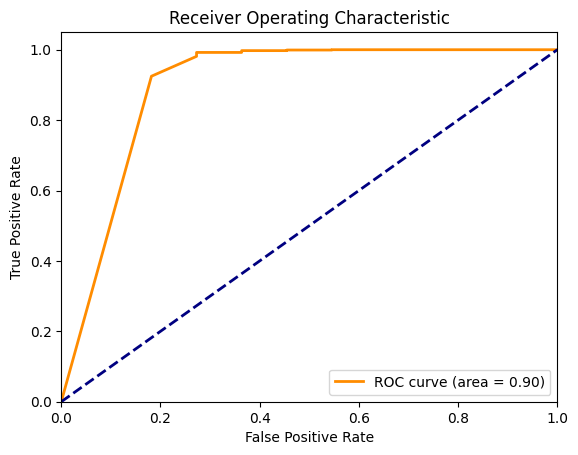

AUC: 0.8969593280970526


In [ ]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_pred_prob = rf_classifier.predict_proba(x_test_scaled)[:, 1]


fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc}")


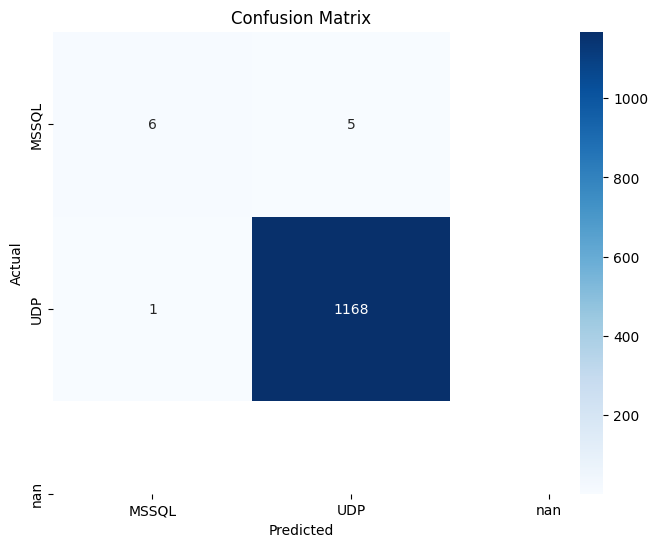

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

tn, fp, fn, tp = cm.ravel()

print(f"True Positive (TP): {tp}")
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")


True Positive (TP): 1168
True Negative (TN): 6
False Positive (FP): 5
False Negative (FN): 1
